* using a wide rhostar prior [UP(0.1, 33)] where upper bound corresponds to densest M dwarf in NExSci yields a bimodal rhostar solution in the contaminated transit model
* we can use a narrow rhostar prior [NP(17,8, 1.5)] based on spectroscopy results

In [58]:
outdir='narrow_rhostar_prior'
# outdir='wide_rhostar_prior'
# outdir='no_contamination' 

In [59]:
from uncertainties import ufloat

zero_epoch = ufloat(2458829.20099, 0.00082)
period = ufloat(2.50031, 0.00001)
star_teff = ufloat(3185, 76)
star_logg = ufloat(4.959, 0.026)
star_z = ufloat(0.336, 0.060)
star_rad = ufloat(0.2775, 0.0080)
star_mass = ufloat(0.255, 0.0066)
star_rho = ufloat(16.8, 1.5)

## data

In [60]:
from glob import glob 

files = glob("../data/lc/*.dat")
files.sort()
files

['../data/lc/TIC470381900-01_20201223_LCO-Hal-M3_gp_10px_bjd-flux-err-am.dat',
 '../data/lc/TIC470381900-01_20201223_LCO-Hal-M3_ip_10px_bjd-flux-err-am.dat',
 '../data/lc/TIC470381900-01_20201223_LCO-Hal-M3_rp_10px_bjd-flux-err-am.dat',
 '../data/lc/TIC470381900-01_20201223_LCO-Hal-M3_zs_10px_bjd-flux-err-am.dat']

In [61]:
import pandas as pd
from numpy import array

exptimes = array([5,4.5,2.1,1.4])/60/24

colnames = "time flux err airmass".split()
lcs = {}
for f in files:
    b = f.split("_")[-3]
    lc = pd.read_csv(f, delimiter="\t", names=colnames, comment='#')
    lcs[b] = lc
    print(f"{b}: {lc.shape}")

gp: (35, 4)
ip: (89, 4)
rp: (41, 4)
zs: (131, 4)


In [62]:
from collections import OrderedDict

lcs = OrderedDict({'g': lcs['gp'],
                   'r': lcs['rp'],
                   'i': lcs['ip'],
                   'z_s': lcs['zs']

    })
lcs.keys()

odict_keys(['g', 'r', 'i', 'z_s'])

In [63]:
lcs['g'].head()

,time,flux,err,airmass
0,2.459207e+06,0.999639,0.005508,1.690677
1,2.459207e+06,0.998265,0.003878,1.628061
2,2.459207e+06,0.999853,0.003655,1.599124
3,2.459207e+06,1.000971,0.003558,1.571578
4,2.459207e+06,0.999497,0.003525,1.545440


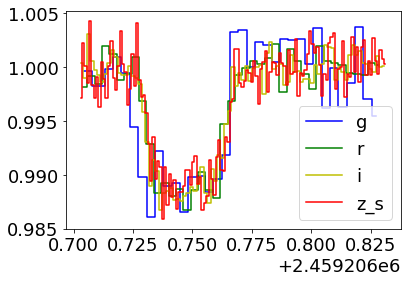

In [64]:
import matplotlib.pyplot as pl

colors = {"g": "b",
          "r": "g", 
          "i": "y", 
          "z_s": "r"
         }

for b in lcs:
    t = lcs[b]['time']
    f = lcs[b]['flux']
#     pl.plot(t, f, c=colors[b], marker='.', ls='', label=b)
    pl.plot(t, f, c=colors[b], drawstyle='steps-mid', label=b)
pl.legend()

## Contaminated LPF

* https://github.com/hpparvi/PyTransit/blob/master/pytransit/lpf/cntlpf.py

In [65]:
target = 'toi1696'

bands = list(lcs.keys())
bands

['g', 'r', 'i', 'z_s']

In [66]:
times,fluxes,errors,pbids=[],[],[],[]
for i,b in enumerate(bands):
    print(b)
    t = lcs[b]['time'].values
    f = lcs[b]['flux']
    e = lcs[b]['err']
    times.append(t)
    fluxes.append(f)
    errors.append(e)
    pbids.append(i)

g
r
i
z_s


In [67]:
pbids = pd.Categorical(bands, categories=bands).codes
pbids

array([0, 1, 2, 3], dtype=int8)

In [68]:
from pytransit.lpf import  BaseLPF
from pytransit.lpf.cntlpf import PhysContLPF

lpf = PhysContLPF(name=target, 
                  passbands=bands,
                  times=times,
                  fluxes=fluxes,
                  errors=errors,
                  pbids=pbids,
                  wnids=range(4),
                  exptimes=exptimes,
                  tref=int(times[0][0])
              )
lpf.ps

[  0 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2_app         U(a = 0.0001, b = 0.0625)                [    0.00 ..     0.06],
   5 |G| k2_true        U(a = 0.0001, b = 0.5625)                [    0.00 ..      inf],
   6 |G| teff_h         U(a = 2500, b = 12000)                   [ 2500.00 .. 12000.00],
   7 |G| teff_c         U(a = 2500, b = 12000)                   [ 2500.00 .. 12000.00],
   8 |P| q1_g           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   9 |P| q2_g           U(a = 0, b = 1)                          [    0.00 ..     1.00],
  10 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
  11 |P| q2_r        

### add priors

In [69]:
"""
use limb darkening priors,
otherwise g-band looks too boxy
probably due to sparse M3 data (especially in g)

should upsample/supersample data?

https://github.com/hpparvi/ldtk/blob/master/notebooks/01_Example_basics.ipynb
"""

from ldtk.filters import sdss_g, sdss_r, sdss_i, sdss_z

passbands = (sdss_g, sdss_r, sdss_i, sdss_z)
lpf.add_ldtk_prior((star_teff.n,star_teff.s), 
                   (star_logg.n, star_logg.s), 
                   (star_z.n,star_z.s), 
                   passbands)

In [70]:
from pytransit.param.parameter import NormalPrior as NP, UniformPrior as UP

# $R_P/R_{\star,T}$ & $0.1016 \pm 0.0065$ \\
# $R_P/R_{\star,g}$ & $0.0997 \pm 0.0063$ \\
# $R_P/R_{\star,r}$ & $0.1025 \pm 0.0028$ \\
# $R_P/R_{\star,i}$ & $0.1020 \pm 0.0020$ \\
# $R_P/R_{\star,z}$ & $0.0999 \pm 0.0020$ \\


lpf.set_prior('zero_epoch', NP(zero_epoch.n, zero_epoch.s))
lpf.set_prior('period', NP(period.n, period.s))
lpf.set_prior('teff_h', NP(star_teff.n, 100)) #inflated uncertainty

#rho_star posterior reaches rho=23 gcc default upper boundary  
#M dwarfs in NExSci have rho<32 gcc
# lpf.set_prior('b', NP(0, 0.01)) 
if outdir=='wide_rhostar_prior':
    lpf.set_prior('rho', UP(1, 42)) 
if outdir=='narrow_rhostar_prior':
    lpf.set_prior('rho', NP(16.8, 1.5)) 
if outdir=='no_contamination':
    lpf.set_prior('k2_app', NP(0.01, 0.0001))
    lpf.set_prior('k2_true', NP(0.01, 0.0001))
lpf.ps

[  0 |G| tc             N(μ = 2458829.20099, σ = 0.00082)        [    -inf ..      inf],
   1 |G| p              N(μ = 2.50031, σ = 1e-05)                [    0.00 ..      inf],
   2 |G| rho            N(μ = 16.8, σ = 1.5)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2_app         U(a = 0.0001, b = 0.0625)                [    0.00 ..     0.06],
   5 |G| k2_true        U(a = 0.0001, b = 0.5625)                [    0.00 ..      inf],
   6 |G| teff_h         N(μ = 3185.0, σ = 100.0)                 [ 2500.00 .. 12000.00],
   7 |G| teff_c         U(a = 2500, b = 12000)                   [ 2500.00 .. 12000.00],
   8 |P| q1_g           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   9 |P| q2_g           U(a = 0, b = 1)                          [    0.00 ..     1.00],
  10 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
  11 |P| q2_r        

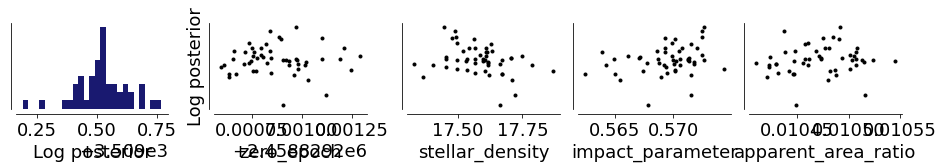

In [71]:
lpf.optimize_global(1000)

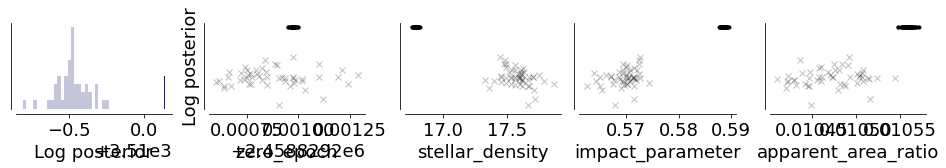

In [72]:
lpf.optimize_global(500)

In [73]:
pv = lpf.de.minimum_location

[Text(0.5, 1.0, 'g'),
 Text(0.5, 1.0, 'r'),
 Text(0.5, 1.0, 'i'),
 Text(0.5, 1.0, 'z_s')]

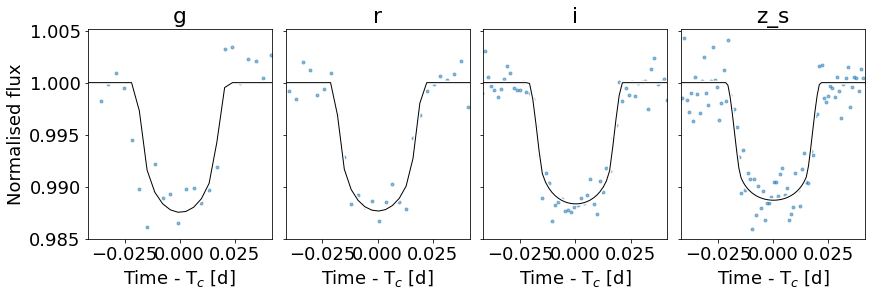

In [74]:
fig = lpf.plot_light_curves(ncol=4, figsize=(12,4))
[ax.set_title(bands[i]) for i,ax in enumerate(fig.axes)]

In [75]:
mc_iter = 5000
lpf.sample_mcmc(mc_iter, repeats=2)

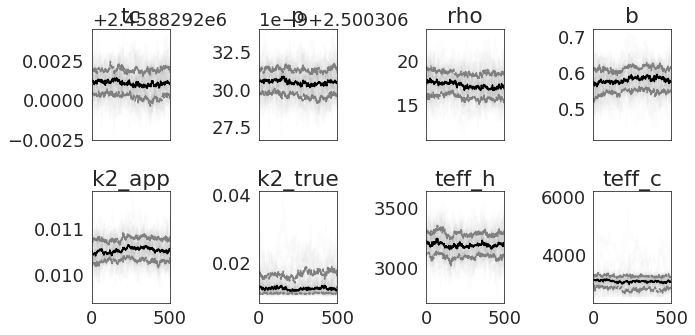

In [76]:
import seaborn as sb
from matplotlib.pyplot import subplots, setp
from numpy import percentile

nparams = 8
ncols = 4
nrows = 2
with sb.axes_style('white'):
    fig, axs = subplots(nrows,ncols, figsize=(10,5), sharex=True)
    ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
    percs = [percentile(lpf.sampler.chain[:,:,i], [50,16,84], 0) for i in range(nparams)]
    [axs.flat[i].plot(lpf.sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(nparams)]
    [[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(nparams)]
    [axs.flat[i].set_title(lpf.ps.names[i]) for i in range(nparams)]
    setp(axs, xlim=[0,mc_iter//10])
    fig.tight_layout()

[Text(0.5, 1.0, 'g'),
 Text(0.5, 1.0, 'r'),
 Text(0.5, 1.0, 'i'),
 Text(0.5, 1.0, 'z_s')]

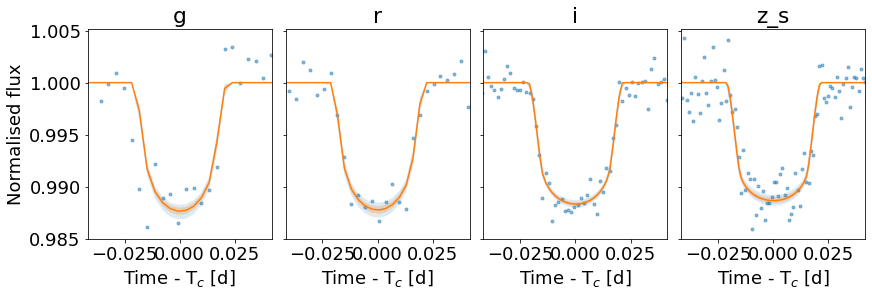

In [77]:
fig = lpf.plot_light_curves(ncol=4, figsize=(12,4), method='mcmc')
[ax.set_title(bands[i]) for i,ax in enumerate(fig.axes)]

In [78]:
df = lpf.posterior_samples()
df.head()

,tc,p,rho,b,k2_app,k2_true,teff_h,teff_c,q1_g,q2_g,...,wn_loge_0,wn_loge_1,wn_loge_2,wn_loge_3,a,inc,k_app,k_true,t14,cref
0,2.458829e+06,2.500306,15.710393,0.607102,0.010700,0.011785,3094.347106,3192.450579,0.747816,0.343037,...,-2.552215,-2.877150,-2.962127,-2.756375,17.315903,1.535729,0.103441,0.108560,0.042678,0.092092
1,2.458829e+06,2.500306,15.698830,0.607484,0.010712,0.011771,3105.284417,3170.596785,0.747099,0.343153,...,-2.551529,-2.876346,-2.963243,-2.756248,17.311654,1.535698,0.103497,0.108494,0.042674,0.089999
2,2.458829e+06,2.500306,15.778331,0.608385,0.010757,0.011586,3095.270745,3094.487950,0.745033,0.343296,...,-2.564166,-2.879758,-2.965969,-2.754807,17.340828,1.535705,0.103718,0.107639,0.042528,0.071532
3,2.458829e+06,2.500306,16.440464,0.587517,0.010629,0.012261,3073.321430,3114.598483,0.728265,0.347160,...,-2.581439,-2.893106,-2.952068,-2.765624,17.580079,1.537371,0.103097,0.110727,0.042718,0.133064
4,2.458829e+06,2.500306,18.537841,0.526341,0.010278,0.012209,3157.623033,3156.611603,0.725898,0.349988,...,-2.543779,-2.911489,-2.916900,-2.768136,18.297954,1.542027,0.101382,0.110496,0.042569,0.158152


In [79]:
lpf.save(f'../data/contamination/{outdir}')

In [80]:
!ls ../data/contamination/$outdir

toi1696.nc


## contaminated model with baseline
* https://github.com/hpparvi/parviainen_2019b_toi_263/blob/master/src/tmlpf.py

## Analysis

* https://github.com/hpparvi/parviainen_2019b_toi_263/blob/master/6a_analysis.ipynb

* https://github.com/hpparvi/parviainen_2020_toi_519/blob/main/519/6a_analysis.ipynb

In [81]:
from pytransit.orbits import as_from_rhop, i_from_ba, d_from_pkaiews, epoch
from pytransit.utils.eclipses import Teq
from astropy.units import Rjup, Rsun, m, AU
from numpy import zeros, diff, concatenate, sqrt, degrees, radians, array, percentile
from numpy.random.mtrand import normal, uniform
from uncertainties import ufloat, nominal_value
import xarray as xa
import pandas as pd
    
def read_mcmc(fname, flatten=True):
    with xa.open_dataset(fname) as ds:
        npt = ds.mcmc_samples.values.shape[-1]
        name = ds.name
        if flatten:
            df = pd.DataFrame(array(ds.mcmc_samples.values).reshape([-1, npt]), 
                              columns=ds.parameter.values)
            return df, name
        else:
            return array(ds.mcmc_samples.values), name
        
def derive_qois(df_original):
    df = df_original.copy()
    ns = df.shape[0]

    rstar_d = normal(star_rad.n, star_rad.s, size=ns) * Rsun
    period = df.p.values if 'p' in df.columns else df.pr.values

    df['period'] = period
    df['k_true'] = sqrt(df.k2_true)
    df['k_app'] = sqrt(df.k2_app)
    df['cnt'] = 1. - df.k2_app / df.k2_true
    df['a_st'] = as_from_rhop(df.rho.values, period)
    df['a_au'] = df.a_st * rstar_d.to(AU)
    df['inc'] = degrees(i_from_ba(df.b.values, df.a_st.values))
    df['t14'] = d_from_pkaiews(period, df.k_true.values, df.a_st.values, radians(df.inc.values), 0.0, 0.0, 1)
    df['t14_h'] = 24 * df.t14

    df['r_app'] = df.k_app.values * rstar_d.to(Rjup)
    df['r_true'] = df.k_true.values * rstar_d.to(Rjup)
    df['r_app_point'] = df.k_app.values * rstar_d.to(Rjup)
    df['r_true_point'] = df.k_true.values * rstar_d.to(Rjup)

    df['r_app_rsun'] = df.k_app.values * rstar_d.to(Rsun)
    df['r_true_rsun'] = df.k_true.values * rstar_d.to(Rsun)
    df['teff_p'] = Teq(normal(star_teff.n, size=ns), df.a_st, uniform(0.25, 0.50, ns), uniform(0, 0.4, ns))
    return df

d, target = read_mcmc(f'../data/contamination/{outdir}/toi1696.nc')
df = derive_qois(d)
df.head()

,tc,p,rho,b,k2_app,k2_true,teff_h,teff_c,q1_g,q2_g,...,inc,t14,t14_h,r_app,r_true,r_app_point,r_true_point,r_app_rsun,r_true_rsun,teff_p
0,2.458829e+06,2.500306,15.710393,0.607102,0.010700,0.011785,3094.347106,3192.450579,0.747816,0.343037,...,87.990775,0.042678,1.024278,0.287313,0.301532,0.287313,0.301532,0.029525,0.030986,564.131219
1,2.458829e+06,2.500306,15.698830,0.607484,0.010712,0.011771,3105.284417,3170.596785,0.747099,0.343153,...,87.989017,0.042674,1.024166,0.287292,0.301164,0.287292,0.301164,0.029523,0.030948,578.654588
2,2.458829e+06,2.500306,15.778331,0.608385,0.010757,0.011586,3095.270745,3094.487950,0.745033,0.343296,...,87.989425,0.042528,1.020661,0.273097,0.283422,0.273097,0.283422,0.028064,0.029125,553.746770
3,2.458829e+06,2.500306,16.440464,0.587517,0.010629,0.012261,3073.321430,3114.598483,0.728265,0.347160,...,88.084847,0.042718,1.025234,0.284498,0.305552,0.284498,0.305552,0.029236,0.031399,588.610214
4,2.458829e+06,2.500306,18.537841,0.526341,0.010278,0.012209,3157.623033,3156.611603,0.725898,0.349988,...,88.351659,0.042569,1.021658,0.277992,0.302981,0.277992,0.302981,0.028567,0.031135,504.576986


In [82]:
parameters = 'tc p rho b inc teff_h k_app k_true r_true r_app a_st a_au t14_h teff_p cnt'.split()
for p in parameters:
    pqs = percentile(df[p], [50, 16, 84, 99])
    print (f"{p:10} & {pqs[0]:20.7f} & {pqs[1]-pqs[0]:+15.7f} & {pqs[2]-pqs[0]:+15.7f} & P(99) {pqs[-1]:15.7f} \\\\")

tc         &      2458829.2009519 &      -0.0007994 &      +0.0008454 & P(99) 2458829.2029029 \\
p          &            2.5003060 &      -0.0000000 &      +0.0000000 & P(99)       2.5003060 \\
rho        &           17.1309251 &      -1.4264122 &      +1.4113228 & P(99)      20.4755469 \\
b          &            0.5794421 &      -0.0343774 &      +0.0335590 & P(99)       0.6540324 \\
inc        &           88.1371357 &      -0.1631624 &      +0.1545460 & P(99)      88.4939475 \\
teff_h     &         3193.1509505 &    -101.6339668 &    +103.1482820 & P(99)    3433.2828411 \\
k_app      &            0.1026396 &      -0.0011658 &      +0.0012323 & P(99)       0.1053900 \\
k_true     &            0.1107483 &      -0.0061048 &      +0.0159011 & P(99)       0.1560386 \\
r_true     &            0.3002687 &      -0.0189575 &      +0.0423300 & P(99)       0.4233971 \\
r_app      &            0.2771792 &      -0.0085179 &      +0.0085919 & P(99)       0.2972972 \\
a_st       &           17.8228

<AxesSubplot:>

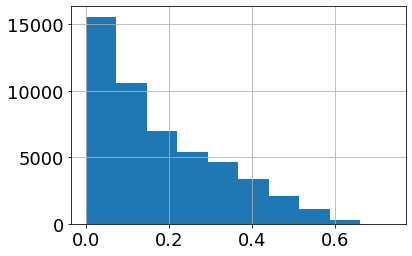

In [83]:
df.cnt.hist()

In [84]:
# $T_\mathrm{eq}$ [K] & $475 \pm 22$ \\
# $T_{14}$ [hours] & $0.99 \pm 0.02$ \\
tdur = 0.99/24
sma = 0.0236
b = 0.55
k = 0.1 

pars = 'tc rho b k_app k_true teff_h teff_c cnt a_au t14'.split()

truths = (zero_epoch.n,
          star_rho.n,
          b,
          k,
          None,
          star_teff.n,
          None,
          None,
          sma,
          tdur,
)

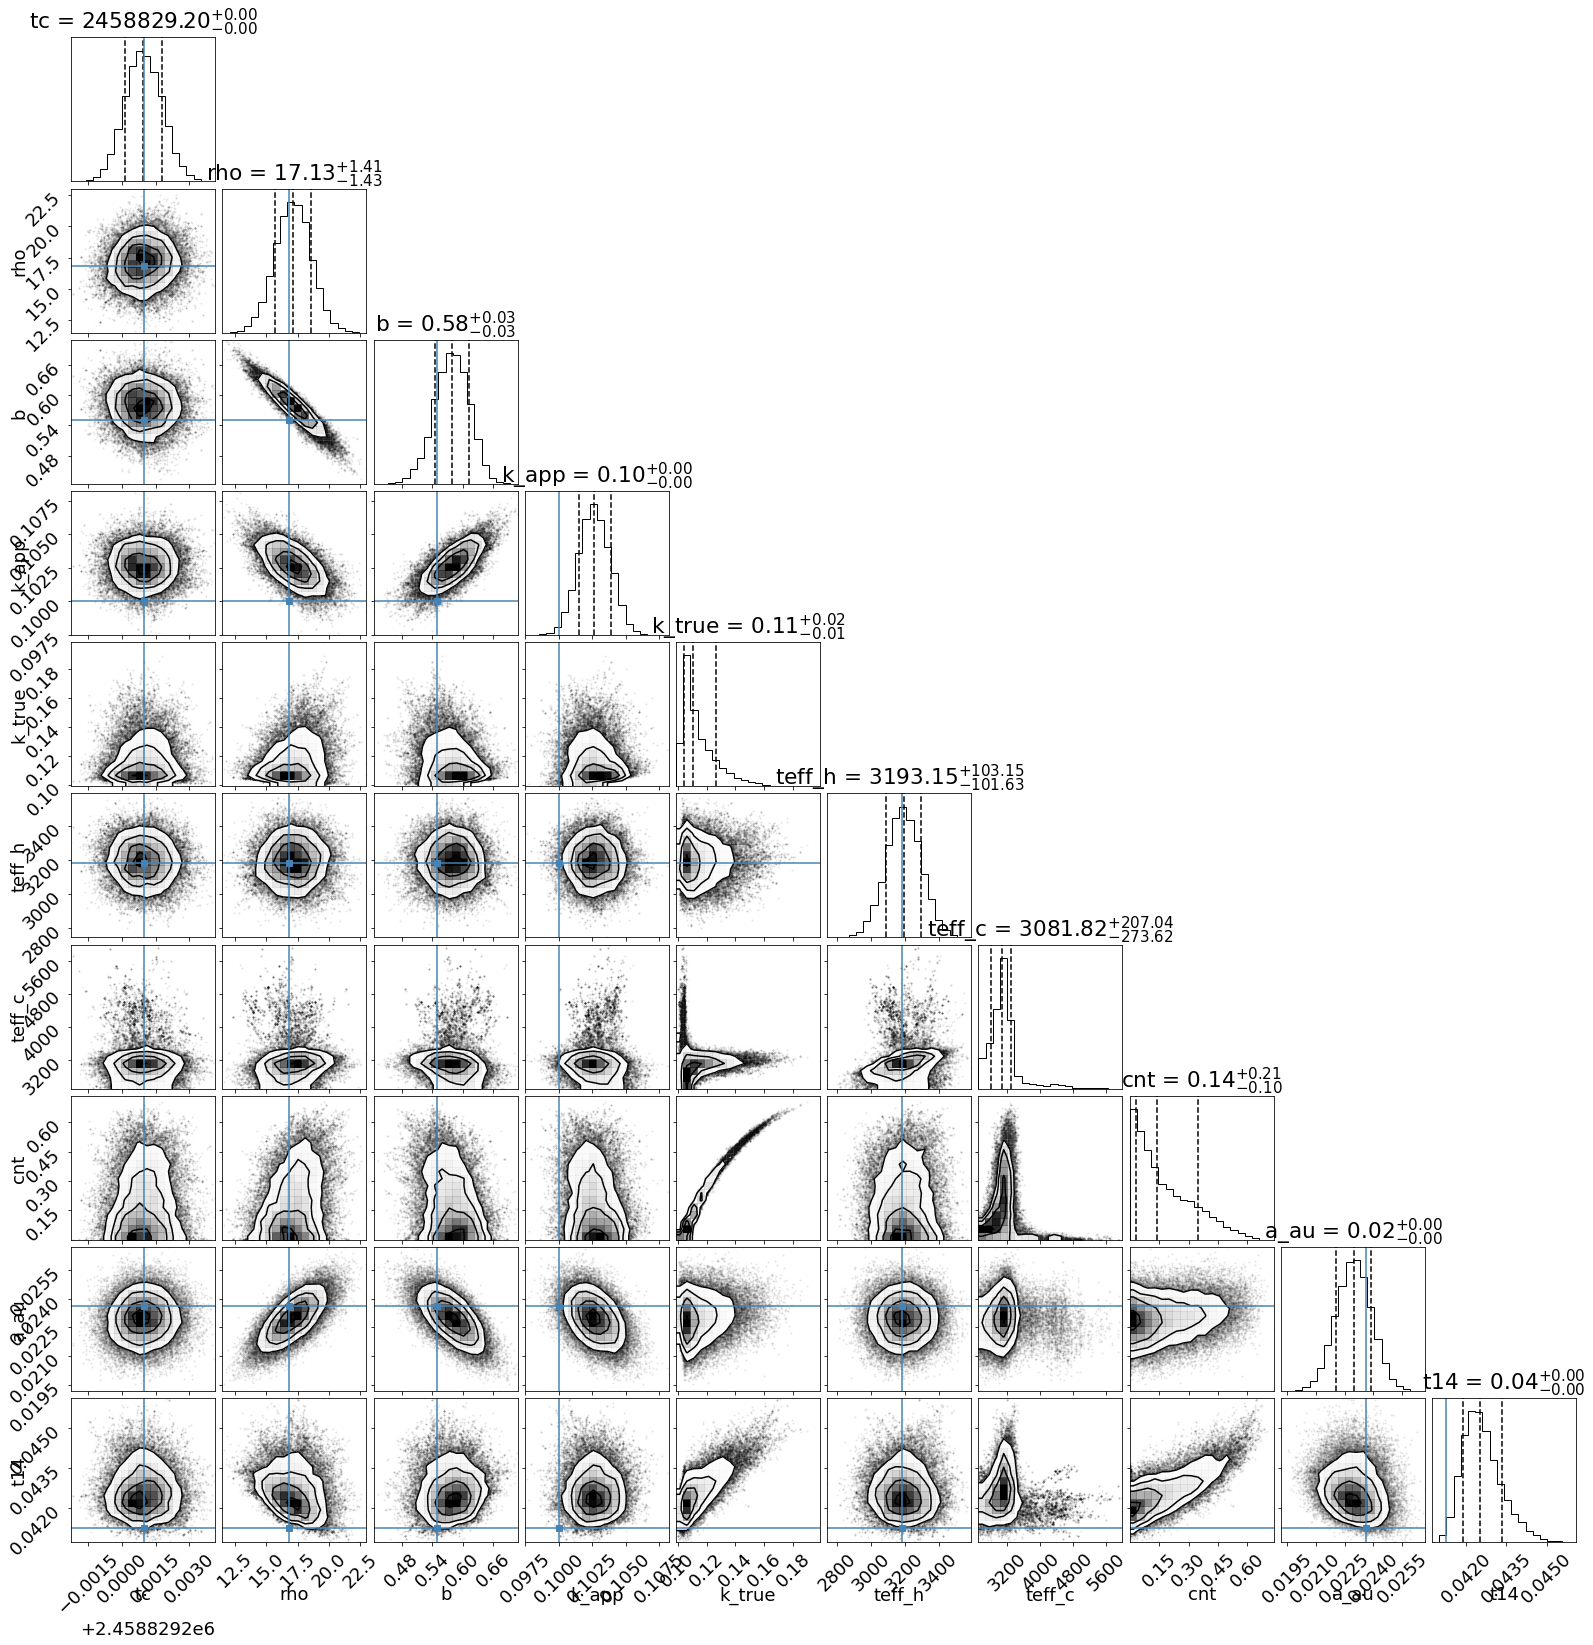

In [85]:
from corner import corner

fig = corner(df[pars], 
             labels=pars, 
             show_titles=True, 
             quantiles=[0.16,0.50,0.84],
             truths=truths
            );

In [86]:
fig.savefig(f'../paper/figures/contaminated_lpf_corner_{outdir}.png', bbox_inches=False, facecolor='w')

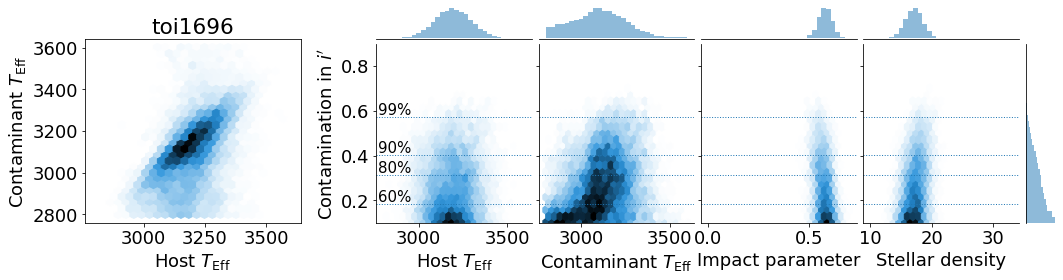

In [87]:
from pytransit.contamination.plotting import joint_marginal_plot
from matplotlib.pyplot import rcParams

rcParams['font.size'] = 18

fig = joint_marginal_plot(df,
                          htelim=(2800,3600),
                          ctelim=(2800,3600),
                          blim=(0.0,0.7),
                          clim=(0.1,0.9),
                          rlim=(10,33),
                          fw=15
#                           figsize=(15,8)
                         )
ps = percentile(df.cnt, [60, 80, 90, 99])
[[ax.axhline(p, lw=1, ls=':') for p in ps] for ax in fig.axes[1:5]]
xmin = fig.axes[1].get_xlim()[0]
[fig.axes[1].text(xmin+10, p+0.01, '{:2d}%'.format(t), size='small') for p,t in zip(ps, [60, 80, 90, 99])]

fig.axes[0].set_title(target);
# setp(fig.axes[0:2], xticks=(2800,3000,3500))

# fig.axes[0].set_xlim(2000,4000)
# fig.axes[0].set_ylim(3000,7000)

# fig.axes[1].set_xlim(2000,4000)
# fig.axes[5].set_xlim(2000,4000)

# fig.axes[2].set_xlim(2000,5000)
# fig.axes[6].set_xlim(2000,5000)

# fig.axes[4].set_xlim(12,16)
# fig.axes[8].set_xlim(12,16)

In [88]:
fig.savefig(f'../paper/figures/contaminated_lpf_jointplot_{outdir}.png', bbox_inches=False, facecolor='w')

[Text(0.1, 0.19591695281903765, '60%'),
 Text(0.1, 0.3250030089245512, '80%'),
 Text(0.1, 0.41340214328572816, '90%'),
 Text(0.1, 0.581260724692002, '99%')]

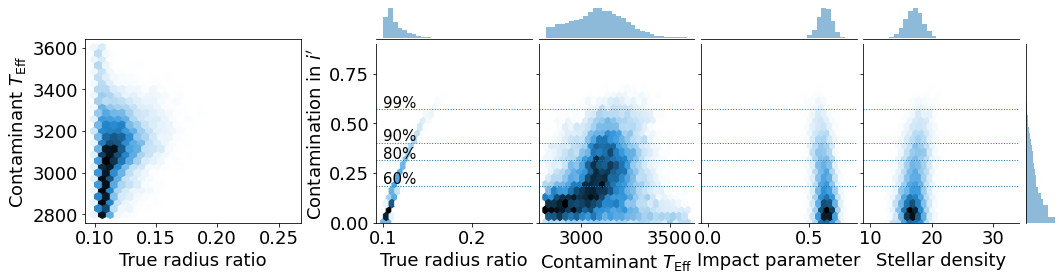

In [89]:
from matplotlib.pyplot import setp
from numpy import percentile
from pytransit.contamination.plotting import _jplot

def joint_marginal_plot2(df, fw=10, nb=30, gs=25, **kwargs):
    return _jplot(df.k_true, df.teff_c, df.cnt, df.b, df.rho, fw, nb, gs, **kwargs)[0]

fig = joint_marginal_plot2(df,
                          htelim=(0.1, 0.26), 
                          ctelim=(2800, 3600),
                          blim=(0, 0.7), 
                          clim=(0, 0.9),
                          rlim=(10,33),
                           fw=15
                         )

setp(fig.axes[0:2], xlabel='True radius ratio')
ps = percentile(df.cnt, [60, 80, 90, 99])
[[ax.axhline(p, lw=1, ls=':') for p in ps] for ax in fig.axes[1:5]]
[fig.axes[1].text(0.1, p+0.01, '{:2d}%'.format(t), size='small') for p,t in zip(ps, [60, 80, 90, 99])]

# fig.axes[4].set_xlim(12,16)
# fig.axes[8].set_xlim(12,16)

## figure for paper

[Text(0.1, 0.19591695281903765, '60%'),
 Text(0.1, 0.3250030089245512, '80%'),
 Text(0.1, 0.41340214328572816, '90%'),
 Text(0.1, 0.581260724692002, '99%')]

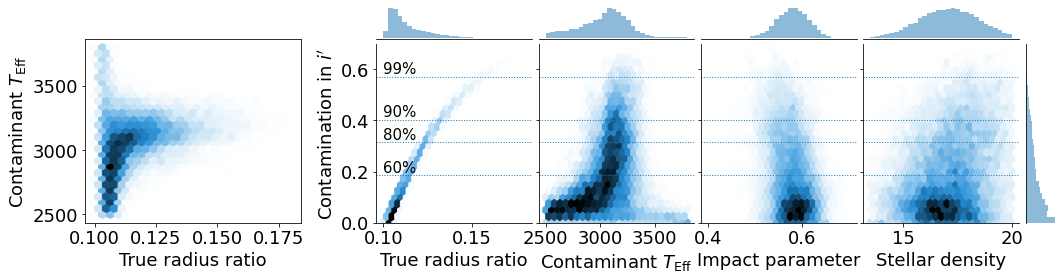

In [90]:
from matplotlib.pyplot import setp
from numpy import percentile
from pytransit.contamination.plotting import _jplot
from matplotlib.pyplot import rcParams

rcParams['font.size'] = 18

def joint_marginal_plot2(df, fw=10, nb=30, gs=25, **kwargs):
    return _jplot(df.k_true, df.teff_c, df.cnt, df.b, df.rho, fw, nb, gs, **kwargs)[0]

fig = joint_marginal_plot2(df,
                          htelim=(0.1, 0.18), 
                          ctelim=(2500, 3800),
                          blim=(0.4, 0.7), 
                          clim=(0, 0.7),
                          rlim=(13.5,20),
                           fw=15
                         )

setp(fig.axes[0:2], xlabel='True radius ratio')
ps = percentile(df.cnt, [60, 80, 90, 99])
[[ax.axhline(p, lw=1, ls=':') for p in ps] for ax in fig.axes[1:5]]
[fig.axes[1].text(0.1, p+0.01, '{:2d}%'.format(t), size='small') for p,t in zip(ps, [60, 80, 90, 99])]

# fig.axes[4].set_xlim(12,16)
# fig.axes[8].set_xlim(12,16)

In [42]:
fig.savefig(f'../paper/figures/contaminated_lpf_jointplot2_{outdir}.png', bbox_inches=False, facecolor='w')

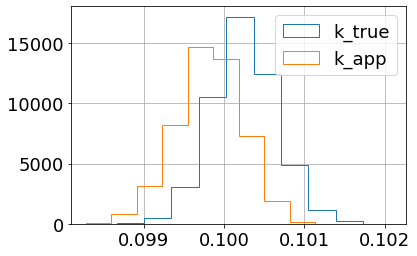

In [38]:
ax = df['k_true'].hist(histtype='step', label='k_true')
df['k_app'].hist(ax=ax, histtype='step', label='k_app')
ax.legend()

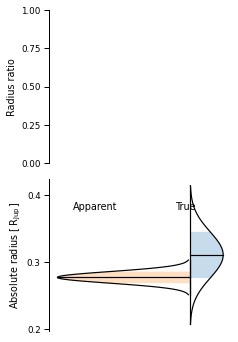

In [92]:
from matplotlib.pyplot import subplots
import seaborn as sb
from scipy.stats import norm
from numpy import  median, argmin, linspace
AAOCW, AAPGW = 3.4645669, 7.0866142

def plot_kdist(samples, sign=1, ax=None, label=None):
    offset = 0.02
    fig, ax = (None, ax) if ax is not None else subplots(figsize=(6,6))
    p = sb.kdeplot(samples, kernel='cos', bw=0.005, gridsize=200, clip=(0.175, 0.29), vertical=True, ax=ax, c='k', legend=False)
    l = p.lines[-1]
    xd = l.get_xdata()
    yd = l.get_ydata()

    m = median(samples)
    my = xd[argmin(abs(yd-m))] / xd.max()
    l.set_xdata(sign*(offset + xd/xd.max()))
    ax.plot((sign*offset,sign*offset), (0.16,0.29), 'k')
    ax.plot((sign*offset, sign*my), (m,m), 'k')
    
    p = percentile(samples, (16,84))
    mask = (yd > p[0]) & (yd < p[1])
    ax.fill_betweenx(yd[mask], sign*(offset+xd[mask]/ xd.max()), alpha=0.25)
    
    #if label:
    #    ax.text(sign*3.5*offset, m+0.0003, label, ha=('left' if sign>0 else 'right'), va='bottom')
    return fig, ax


def plot_ndist(samples, sign=1, yrange=(0.1, 1.4), c='k', ax=None, figsize=(6,6), label=None):
    fig, ax = (None, ax) if ax is not None else subplots(figsize=figsize)
    offset = 0.05
    m, s = samples.mean(), samples.std()
    y = linspace(m-3*s, m+3*s)
    n = norm(m, s)
    ax.plot(sign*(offset + n.pdf(y)), y, c=c)
    ax.plot((sign*offset, sign*(offset+n.pdf(m))),(m, m), c=c)
    ax.plot((sign*offset, sign*offset), (m-3*s, m+3*s), c=c)
    
    y = linspace(m-s, m+s)
    ax.fill_betweenx(y, sign*offset, sign*(offset + n.pdf(y)), alpha=0.25)
    
    #if label:
    #    ax.text(sign*3.5*offset, m+0.1*s, label, ha=('left' if sign>0 else 'right'), va='bottom')
    return fig, ax
    
    
with sb.plotting_context('paper'):
    fig, axs = subplots(2, 1, figsize=(AAOCW,1.4*AAOCW))
    plot_ndist(df.r_true, label='true R$_\mathrm{\,p}$', ax=axs[1])
    plot_ndist(df.r_app, label='apparent R$_\mathrm{\,p}$', sign=-1, ax=axs[1])
    axs[1].text(0.25, 0.8, 'Apparent', ha='center', transform=axs[1].transAxes)
    axs[1].text(0.75, 0.8, 'True', ha='center', transform=axs[1].transAxes)
    
#     plot_kdist(df.k_true, ax=axs[0], label='true k')
#     plot_kdist(df.k_app, sign=-1, ax=axs[0], label='apparent k')
#     axs[0].text(0.25, 0.8, 'Apparent', ha='center', transform=axs[0].transAxes)
#     axs[0].text(0.75, 0.8, 'True', ha='center', transform=axs[0].transAxes)
    
    setp(axs[0], 
#          xlim=(-1.1,1.1), 
#          ylim=(0.178, 0.28), 
         ylabel='Radius ratio', 
         xticks=[])
    setp(axs[1], ylabel='Absolute radius [$\,$R$_\mathrm{Jup}\,$]', xticks=[])

    #axs[0].set_title('Planet-star radius ratio', size='large')
    #axs[1].set_title('Absolute planet radius', size='large')

    sb.despine(fig, bottom=True)
    fig.tight_layout()
#     fig.savefig('../paper/figures/k_and_rp_distributions.pdf')